In [1]:
% cd /mnt/fs1/mayu-ot/Experiments/loc_iparaphrasing

/mnt/fs1/mayu-ot/Experiments/loc_iparaphrasing


In [264]:
import pandas as pd
import json
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import imageio
import chainer
from func.datasets.datasets import DDPNBBoxDataset, get_most_similar, BBoxDataset
from chainercv.visualizations import vis_bbox
import textwrap

In [3]:
img_dir = 'data/flickr30k-images/'

In [242]:
bbox_data = DDPNBBoxDataset('test')
gt_bbox_data = BBoxDataset('test')

In [252]:
bbox_df = bbox_data.df.copy()
gt_bbox_df = gt_bbox_data.df.copy()
gt_bbox_df = gt_bbox_df.reset_index()

In [7]:
ours_df = pd.read_csv('bo_out/vis+lng+ddpn+mult/18-20181108-015934/res_test.csv')
phr_df = pd.read_csv('bo_out/lng/13-20181102-020120/res_test.csv')
vis_df = pd.read_csv('bo_out/vis+ddpn/7-20181107-221739/res_test.csv')

In [8]:
ours_correct = (ours_df.ypred == ours_df.ytrue)
phr_correct = (phr_df.ypred == phr_df.ytrue)

In [253]:
gt_bbox_df[gt_bbox_df.image == 390369]

,image,org_phrase,ymin,xmin,ymax,xmax,n_id
0,390369,A gold colored street performer,125,4,431,229,0
1,390369,A person,125,4,431,229,1
2,390369,A street performer,125,4,431,229,2
3,390369,The people,149,1,303,327,3
4,390369,a costume,159,1,435,235,4
5,390369,a dress,159,1,435,235,5
6,390369,a statue,125,4,431,229,6
7,390369,the woman,125,4,431,229,7


In [289]:
i

451

Ours: VGP, Phrase-only: non-VGP, Visual-only: VGP, Ground truth: non-VGP


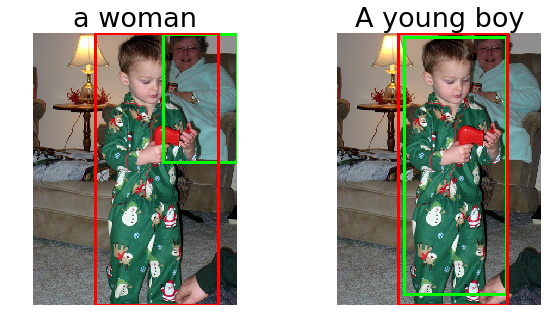

In [290]:
ours_better = ours_df[(ours_correct == False) & (phr_correct == True)]
i = np.random.randint(len(ours_better))
i = 451
item = ours_better.iloc[i]
image = item.image
phrase1 = item.phrase1
phrase2 = item.phrase2
org_phrase1 = item.original_phrase1
org_phrase2 = item.original_phrase2
pred = item.ypred
ytrue = item.ytrue
vis_item = vis_df[(vis_df.image == image) & (vis_df.phrase1 == phrase1) & (vis_df.phrase2 == phrase2)].iloc[0]

im = imageio.imread(img_dir + str(image) + '.jpg')

fig = plt.figure(figsize=(10, 5))
for j, p, org_phrase in zip(range(2), [phrase1, phrase2], [org_phrase1, org_phrase2]):
    ax = fig.add_subplot(1,2,j+1)
    
    # show gt bbox
    bbox = gt_bbox_df[(gt_bbox_df.image == image) & (gt_bbox_df.org_phrase == org_phrase)][['ymin', 'xmin', 'ymax', 'xmax']]
    bbox = bbox.values
    vis_bbox(im.transpose(2, 0, 1), bbox, ax=ax, instance_colors=[[0, 255, 0]])
    
    # show predicted
    phrases = bbox_df[(bbox_df.image == image)].phrase
    p_ = get_most_similar(p, phrases)
    bbox = bbox_df[(bbox_df.image == image) & (bbox_df.phrase == p_)][['ymin', 'xmin', 'ymax', 'xmax']]
    bbox = bbox.values
    vis_bbox(im.transpose(2, 0, 1), bbox, ax=ax)
    
    ax.set_title(textwrap.fill(org_phrase, 20), fontsize=27)
    ax.axis('off')

# plt.suptitle()
# plt.tight_layout()
label = ['non-VGP', 'VGP']
res = 'Ours: %s, Phrase-only: %s, Visual-only: %s, Ground truth: %s'%(label[int(pred)],
                                                                      label[int(not pred)],
                                                                      label[int(vis_item.ypred)],
                                                                      label[int(ytrue)])
print(res)
plt.savefig('figures/cvpr/supplementary/tmp/%i.png'%i, bbox_inches='tight')
with open('figures/cvpr/supplementary/tmp/%i.txt'%i, 'w') as f:
    f.write(res)

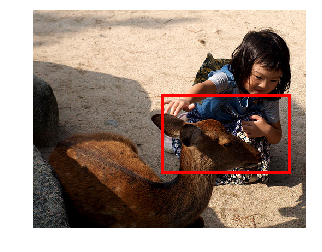

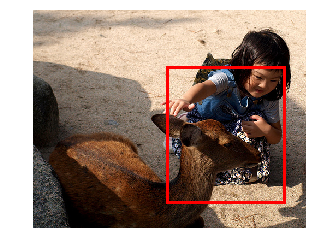

In [92]:
for p in [phrase1, phrase2]:
    phrases = bbox_df[(bbox_df.image == image)].phrase
    p_ = get_most_similar(p, phrases)
    bbox = bbox_df[(bbox_df.image == image) & (bbox_df.phrase == p_)][['ymin', 'xmin', 'ymax', 'xmax']]
    bbox = bbox.values
    vis_bbox(im.transpose(2, 0, 1), bbox)
    plt.axis('off')
    plt.savefig('figures/cvpr/examples/phrase_better/%i_%s.png'%(image, p), bbox_inches='tight')

In [5]:
# visual clue helped paraphrase classification

def load_results(base_dir, non_vis_base_dir):
    df_vis = pd.read_csv(base_dir + 'res_test.csv')
    df_non_vis = pd.read_csv(non_vis_base_dir + 'res_test.csv')
    df_input = pd.read_csv('data/pl-clc/phrase_pair_test.csv')
    return df_vis, df_non_vis, df_input
    

def write_html_doc(base_dir, non_vis_base_dir, visual_better = True):
    df_vis, df_non_vis, df_input = load_results(base_dir, non_vis_base_dir)
    res_vis = (df_vis.ypred == df_vis.ytrue)
    res_non_vis = (df_non_vis.ypred == df_non_vis.ytrue)
    
    df_vis = pd.read_csv(base_dir+'res_test.csv')
    df_non_vis = pd.read_csv(non_vis_base_dir+'res_test.csv')
    df_input = pd.read_csv('data/pl-clc/phrase_pair_test.csv')

    att_dir = base_dir + 'attention_images/'
    out_name = 'visual_better.html' if visual_better else 'non-visual_better.html'
    
    with open(base_dir + out_name, 'w') as f:
        f.write(head_template)
        for i, row in df_vis[(res_vis == visual_better) & (res_non_vis == (not visual_better))].iterrows():
            img_src = img_dir + '%i.jpg'%row['image']
            img_item = img_template.format(img_src)

            att_item1 = txt_template.format(row['phrase1']) + img_template.format(att_dir + '%i-%s.jpg'%(row['image'], row['phrase1']))
            att_item2 = txt_template.format(row['phrase2']) + img_template.format(att_dir + '%i-%s.jpg'%(row['image'], row['phrase2']))

            text_item = txt_template.format('{} == {} ?'.format(df_input.iloc[i]['org_phrase1'], df_input.iloc[i]['org_phrase2']))
            text_item += txt_template.format('GT: {}'.format(row['ytrue']))
            text_item += txt_template.format('Vis: {}'.format(row['ypred']))
            text_item += txt_template.format('non-Vis: {}'.format(not row['ypred']))
            f.write(row_template.format(img_item, att_item1, att_item2, text_item))
        f.write(bottom_template)

In [ ]:
write_html_doc('bo_out/frcnn+wea/plclc-roi/14-frcnn+wea-plclc-roi_20180413-165302/', 'bo_out/none+wea/wo-vis/11-none+wea-wo-vis_20180410-220417/', True)
write_html_doc('bo_out/frcnn+wea/plclc-roi/14-frcnn+wea-plclc-roi_20180413-165302/', 'bo_out/none+wea/wo-vis/11-none+wea-wo-vis_20180410-220417/', False)

In [32]:
from IPython import display

def show_html_doc(base_dir, non_vis_base_dir, visual_better = True):
    df_vis, df_non_vis, df_input = load_results(base_dir, non_vis_base_dir)
    res_vis = (df_vis.ypred == df_vis.ytrue)
    res_non_vis = (df_non_vis.ypred == df_non_vis.ytrue)
    
    df_vis = pd.read_csv(base_dir+'res_test.csv')
    df_non_vis = pd.read_csv(non_vis_base_dir+'res_test.csv')
    df_input = pd.read_csv('data/pl-clc/phrase_pair_test.csv')

    att_dir = '/' + base_dir + 'attention_images/'
#     out_name = 'visual_better.html' if visual_better else 'non-visual_better.html'
    img_dir = '/data/flickr30k-images/'
    print(att_dir)
    print(img_dir)
    
    html = head_template
    
    df_smpl = df_vis[(res_vis == visual_better) & (res_non_vis == (not visual_better))]
    print(len(df_smpl))
    df_smpl = df_smpl[::20]
    
    for i, row in df_smpl.iterrows():
        img_src = img_dir + '%i.jpg'%row['image']
        img_item = img_template.format(img_src)

        att_item1 = txt_template.format(row['phrase1']) + img_template.format(att_dir + '%i-%s.jpg'%(row['image'], row['phrase1']))
        att_item2 = txt_template.format(row['phrase2']) + img_template.format(att_dir + '%i-%s.jpg'%(row['image'], row['phrase2']))

        text_item = txt_template.format('{} == {} ?'.format(df_input.iloc[i]['org_phrase1'], df_input.iloc[i]['org_phrase2']))
        text_item += txt_template.format('GT: {}'.format(row['ytrue']))
        text_item += txt_template.format('Vis: {}'.format(row['ypred']))
        text_item += txt_template.format('non-Vis: {}'.format(not row['ypred']))
        html += row_template.format(img_item, att_item1, att_item2, text_item)
        
    
    return html+bottom_template
#         display.HTML(html)
#         break

html = show_html_doc('bo_out/frcnn+wea/plclc-roi/14-frcnn+wea-plclc-roi_20180413-165302/', 'bo_out/none+wea/wo-vis/11-none+wea-wo-vis_20180410-220417/', False)

/bo_out/frcnn+wea/plclc-roi/14-frcnn+wea-plclc-roi_20180413-165302/attention_images/
/data/flickr30k-images/
1042


In [33]:
display.HTML(html)

Image,Attention 1,Attention 2,Results
,beach,ocean,the beach == the ocean ? GT: False Vis: True non-Vis: False
,artist,pottery+maker,An artist == A pottery maker ? GT: True Vis: False non-Vis: True
,various+used+toys,merchandise,various used toys == merchandise ? GT: True Vis: False non-Vis: True
,petals,bubbles,the petals == bubbles ? GT: False Vis: True non-Vis: False
,traffic+director,man,A traffic director == A man ? GT: True Vis: False non-Vis: True
,man,boy,a man == A boy ? GT: True Vis: False non-Vis: True
,large+brown+dog,big+dog,A large brown dog == A big dog ? GT: True Vis: False non-Vis: True
,stick,toys,stick == toys ? GT: False Vis: True non-Vis: False
,false+eyebrows,joke+glasses,false eyebrows == joke glasses ? GT: False Vis: True non-Vis: False
,game+score,golf+course,the game score == a golf course ? GT: False Vis: True non-Vis: False


In [23]:
import tables
df_roi = pd.read_csv('data/pl-clc/phrase_pair_wt_plclcbbox_test.csv')
roi_file = tables.open_file('data/region_feat/roi/full_test.h5')

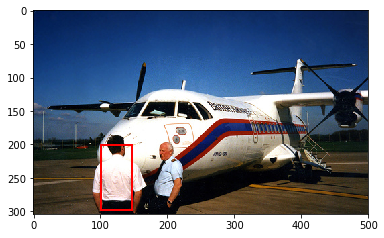

In [20]:
im = plt.imread('data/flickr30k-images/76466808.jpg')
im = draw_bbox(im.copy(), [100, 200, 150, 300], (255, 0, 0), width=3)
plt.imshow(im)

In [24]:
import os


def draw_bbox(img, bounding_box, color, width = 1):
    '''
    bounding_box: (xmin, ymin, xmax, ymax)
    '''
    img[bounding_box[1]:bounding_box[1]+width, bounding_box[0]:bounding_box[2]-1] = color
    img[bounding_box[1]:bounding_box[3]-1, bounding_box[0]:bounding_box[0]+width] = color

    img[bounding_box[3]-1-width:bounding_box[3]-1, bounding_box[0]:bounding_box[2]-1] = color
    img[bounding_box[1]:bounding_box[3]-1, bounding_box[2]-1-width:bounding_box[2]-1] = color
    return img
    
def plot_attention_map(im, roi):
    att_map = np.ones(im.shape[:2])

    for r in roi:
        xmin, ymin, xmax, ymax = r.ravel()
        att_map[ymin:ymax, xmin:xmax] = .3

    att_map = cmap(att_map)[:,:,:3]
    im_out = im / 255. * .5 + att_map * .5
    return im_out

def plot_bbox(im, roi):
    for r in roi:
        im = draw_bbox(im, r.ravel(), color=(255, 0, 0), width=3)
    return im

def save_grounding_img(base_dir, non_vis_base_dir, visual_better=True):
    df_vis, df_non_vis, df_input = load_results(base_dir, non_vis_base_dir)
    res_vis = (df_vis.ypred == df_vis.ytrue)
    res_non_vis = (df_non_vis.ypred == df_non_vis.ytrue)
    
    out_dir = base_dir + 'attention_images/'
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
        
    cmap = plt.get_cmap('Greys')

    for i, row in df_vis[(res_vis == visual_better) & (res_non_vis == (not visual_better))].iterrows():
        im = plt.imread(img_dir + '%i.jpg'%row['image'])
        # get roi proposals
        rois = roi_file.get_node('/', str(row['image'])).read()


        res = df_roi[(df_roi.image == row['image']) & (df_roi.phrase1 == row['phrase1']) & (df_roi.phrase2 == row['phrase2'])]

        roi1 = rois[res['roi1']]
        roi2 = rois[res['roi2']]

        for roi, p in zip([roi1, roi2], [row['phrase1'], row['phrase2']]):
            im_out = plot_bbox(im.copy(), roi)
#             im_out = plot_attention_map(im, roi)

            imageio.imsave(out_dir+'%i-%s.jpg'%(row['image'], p), im_out)

In [30]:
save_grounding_img('bo_out/frcnn+wea/plclc-roi/14-frcnn+wea-plclc-roi_20180413-165302/', 'bo_out/none+wea/wo-vis/11-none+wea-wo-vis_20180410-220417/', False)